In [1]:
!pip install pandas

In [5]:
!pip install zstd dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 639.6 kB/s eta 0:00:0000:0100:01


## Commuting Map construction


---

```
Reggio et al, Fast Partitioning of Pauli Strings into Commuting Families for Optimal Expectation Value Measurements of Dense Operators, 2023-06-07
```

```
Schmitz et al, Graph Optimization Perspective for Low-Depth Trotter-Suzuki Decomposition, 2023-05-26
```

In [1]:
from collections import OrderedDict

import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"font.serif": "Times New Roman"})

from pauli_op import Pauli2String,  PauliDecompose

In [2]:
# Load molecular hamiltonian from Pennylane Dataset
# https://pennylane.ai/qml/datasets_qchem/
MOLECULE_NAME = "H2"
bondlength  = 2.1
dirname = "dataset_processed"

In [84]:
str(data.molecule)

'<Molecule = H2, Charge: 0, Basis: STO-3G, Orbitals: 2, Electrons: 2>'

In [44]:
data = qml.data.load("qchem", molname=MOLECULE_NAME , basis="STO-3G", bondlength  = bondlength)[0]
Hamiltonian = data.hamiltonian
hamiltonian_basis = Hamiltonian.terms()[1]
qubits = len(Hamiltonian.wires)

In [45]:
# Convert to strings
p_strings = []
for p in hamiltonian_basis:
    p_strings.append(Pauli2String(p,qubits))

In [46]:
Z_family = []
X_family = []

P_strings = {}
for p in p_strings:
    P_strings[p] = PauliDecompose(p)
    type_s, z_st, x_st = PauliDecompose(p)
    if type_s == 0:
        Z_family.append(z_st)
    elif type_s ==1:
        X_family.append(x_st)
    else:
        Z_family.append(z_st)
        X_family.append(x_st)

In [47]:
re_Z_family = list(OrderedDict.fromkeys(Z_family))
re_X_family = list(OrderedDict.fromkeys(X_family))
z_dim = len(re_Z_family)
x_dim = len(re_X_family)


In [48]:
print(f"Reduce Z_family duplication:{len(Z_family)} -> {len(re_Z_family)}")
print(f"Reduce X_family duplication:{len(X_family)} -> {len(re_X_family)}")

Reduce Z_family duplication:15 -> 11
Reduce X_family duplication:4 -> 1


In [49]:
print(f"Basis dim: {len(p_strings)}")
print(f"Family dim: {z_dim*x_dim + z_dim + x_dim}")

Basis dim: 15
Family dim: 23


In [50]:
df = pd.DataFrame.from_dict(P_strings, orient="index", columns = ["type", "Z", "X"])
df= df.sort_values("type")
df = df.replace("", None)
df["Znum"] = df["Z"].apply(lambda x: int(x.replace("Z", "1").replace("I", "0"),2) if x is not None else 0).astype(int)
df["Xnum"] = df["X"].apply(lambda x: int(x.replace("X", "1").replace("I", "0"),2) if x is not None else 0).astype(int)
df= df.sort_values(by=["type", "Znum", "Xnum"])
df.reset_index(inplace=True, names="Pstring")

In [51]:
df.tail(10)

,Pstring,type,Z,X,Znum,Xnum
5,IZIZ,0,IZIZ,None,5,0
6,IZZI,0,IZZI,None,6,0
7,ZIII,0,ZIII,None,8,0
8,ZIIZ,0,ZIIZ,None,9,0
9,ZIZI,0,ZIZI,None,10,0
10,ZZII,0,ZZII,None,12,0
11,XXYY,2,IIZZ,XXXX,3,15
12,XYYX,2,IZZI,XXXX,6,15
13,YXXY,2,ZIIZ,XXXX,9,15
14,YYXX,2,ZZII,XXXX,12,15


In [52]:
zdf = df[["Znum"]].drop_duplicates()
xdf = df[["Xnum"]].drop_duplicates()
zdf = zdf.reset_index(drop=True).reset_index(names="zindex")
xdf = xdf.reset_index(drop=True).reset_index(names="xindex")

In [53]:
zdf.tail(5)

,zindex,Znum
6,6,6
7,7,8
8,8,9
9,9,10
10,10,12


In [54]:
xdf.tail(5)

,xindex,Xnum
0,0,0
1,1,15


In [55]:
df = df.merge(zdf, left_on="Znum", right_on='Znum')
df = df.merge(xdf, left_on="Xnum", right_on='Xnum')


In [56]:
df= df.sort_values(by=["type", "Znum", "Xnum"]).reset_index()

In [59]:
df.to_csv(f"{dirname}/{MOLECULE_NAME}-{bondlength}_node.csv",encoding="UTF-8")

In [61]:
zdim = df["zindex"].max() +1
xdim = df["xindex"].max() +1
basis = np.zeros([xdim, zdim])
basis[df["xindex"].values, df["zindex"].values] = 1

In [62]:
plt.rcParams['mathtext.fontset'] = 'cm'

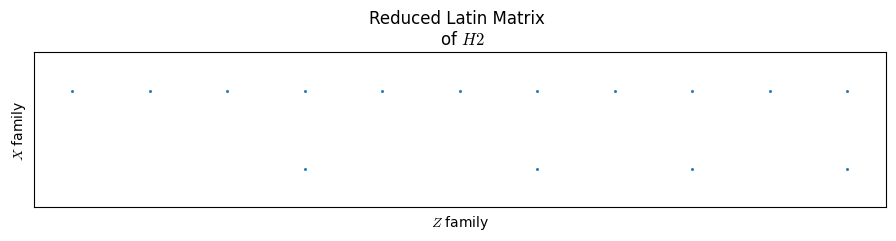

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(11,6))
ax.spy(basis, markersize=1)
ax.set_title(f"Reduced Latin Matrix \n of ${MOLECULE_NAME}$")
ax.set_ylabel("$X$ family")
ax.set_xlabel("$Z$ family")
ax.tick_params(axis='both', which='both', length=0)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

plt.show()

### Edge List generation

In [64]:
from itertools import combinations

In [65]:
edge_df = pd.DataFrame(combinations(df["Pstring"].values ,2), columns=['source', 'target'])

In [66]:
edge_df.sort_values

<bound method DataFrame.sort_values of     source target
0     IIII   IIIZ
1     IIII   IIZI
2     IIII   IIZZ
3     IIII   IZII
4     IIII   IZIZ
..     ...    ...
100   XXYY   YXXY
101   XXYY   YYXX
102   XYYX   YXXY
103   XYYX   YYXX
104   YXXY   YYXX

[105 rows x 2 columns]>

In [67]:
def commute(s):
    return ((s[0] & s[3])<1)==((s[1] &s[2])<1)
def weight(s):
    binary_z = bin(abs((s[0] & s[1])^ (s[2]&s[3])))
    binary_x = bin(abs((s[1]^s[3])))
    return (binary_z + binary_x).count("1")

In [69]:
edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left_on="source", right_on='Pstring').drop("Pstring", 1)
edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left_on="target", right_on='Pstring').drop("Pstring", 1)
edge_df["commute"] = edge_df[["Znum_x", "Xnum_x", "Znum_y", "Xnum_y"]].apply(commute, axis=1)
edge_df["weight"] = edge_df[["Znum_x", "Xnum_x", "Znum_y", "Xnum_y"]].apply(weight, axis=1)/qubits

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8367/2345351891.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left_on="source", right_on='Pstring').drop("Pstring", 1)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8367/2345351891.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Xnum_x', 'Znum_x'} in the result is deprecated and will raise a MergeError in a future version.
  edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left_on="target", right_on='Pstring').drop("Pstring", 1)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8367/2345351891.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left

In [70]:
edge_df.to_csv(f"{dirname}/{MOLECULE_NAME}-{bondlength}_edge.csv",encoding="UTF-8")

In [3]:
from pauli_op import hamiltonian_processing

In [4]:
import pennylane as qml

In [6]:
moles = ["H2", "H3+", "H4", "HeH+", "HF", "LiH", "OH-"]
bondlengths = [2.1, 2.1, 1.3, 2.1, 2.1, 2.1, 2.1]
for mol, bond in zip(moles, bondlengths): 
    hamiltonian_processing(mol, bond)

/Users/hyunseongkim/Documents/GitHub/Quantum_Computing/2023SummerPresentation/pauli_op.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left_on="source", right_on='Pstring').drop("Pstring", 1)
/Users/hyunseongkim/Documents/GitHub/Quantum_Computing/2023SummerPresentation/pauli_op.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="left", left_on="target", right_on='Pstring').drop("Pstring", 1)
/Users/hyunseongkim/Documents/GitHub/Quantum_Computing/2023SummerPresentation/pauli_op.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  edge_df = edge_df.merge(df[["Pstring", "Znum", "Xnum"]], how="le

---

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
df_node = pd.read_csv("dataset_processed/"+"OH--2.1_node.csv")
df_edge = pd.read_csv("dataset_processed/"+"OH--2.1_edge.csv")

In [9]:
z_f_list = df.loc[df["xindex"]==0]["Pstring"]
x_f_list = df.loc[df["zindex"]==0]["Pstring"]

NameError: name 'df' is not defined

In [10]:
# Whole Graph
G = nx.from_pandas_edgelist(edge_df, source='source', target='target', edge_attr
=['commute', "weight"])
commute_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["commute"]]
acommute_edges = [(u, v) for (u, v, d) in G.edges(data=True) if not d["commute"]]

NameError: name 'edge_df' is not defined

In [11]:
commute_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["commute"]]
acommute_edges = [(u, v) for (u, v, d) in G.edges(data=True) if not d["commute"]]

NameError: name 'G' is not defined

In [37]:
# kamada_kawai
# spectral
node_position = nx.circular_layout(G)

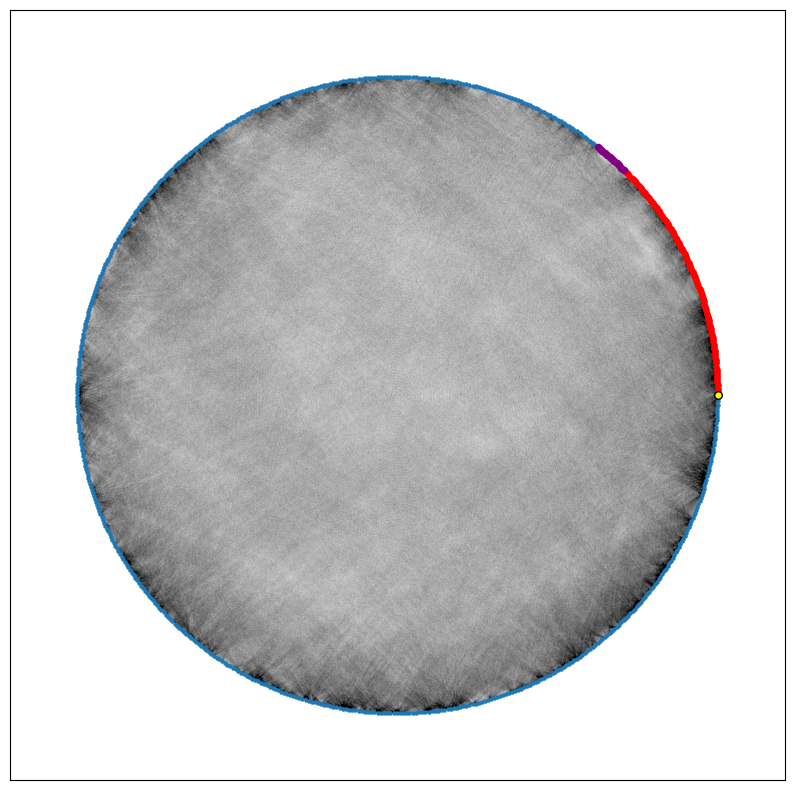

In [38]:
fig, ax= plt.subplots(1,1, figsize=(10, 10))
# Draw all nodes
# Draw commute edges
edges = nx.draw_networkx_edges(
    G, node_position, edgelist= commute_edges , width=0.001, alpha=0.9,
    ax=ax)

nodes = nx.draw_networkx_nodes(
    G, pos=node_position,
    node_size = 5,
    linewidths = 1,
    #edgecolors="black",
    ax=ax
)

z_f_nodes = nx.draw_networkx_nodes(
    G, pos=node_position,
    node_size = 15,
    node_color = "red",
    nodelist= z_f_list,
    linewidths = 1,
    edgecolors="red",
    ax=ax
)
x_f_nodes =nx.draw_networkx_nodes(
    G, pos=node_position,
    node_size = 20,
    node_color = "purple",
    nodelist= x_f_list,
    linewidths = 1,
    edgecolors="purple",
    ax=ax
)

Inode =nx.draw_networkx_nodes(
    G, pos=node_position,
    node_size = 30,
    node_color = "yellow",
    nodelist= ["IIIIIIIIIIII"],
    linewidths = 1,
    edgecolors="black",
    ax=ax
)

In [39]:
fig.savefig("Li_commuting_map.pdf", format="pdf", bbox_inches="tight")

In [40]:
adj_matrix_commute = nx.adjacency_matrix(G, dtype=int, weight="commute")

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_5691/4256892781.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix_commute = nx.adjacency_matrix(G, dtype=int, weight="commute")


Text(0.5, 1.0, '$LiH$ Commute relationship')

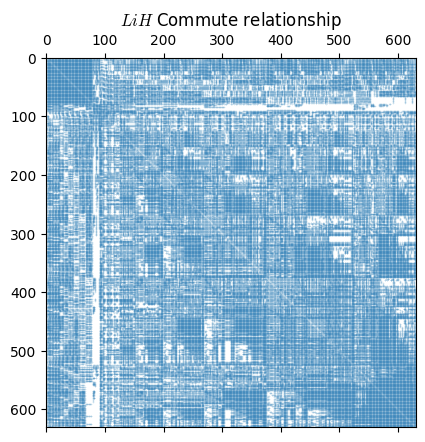

In [41]:
plt.spy(adj_matrix_commute, markersize=0.05)
plt.title("$LiH$ Commute relationship")

In [42]:
adj_matrix_weight = nx.adjacency_matrix(G, dtype=float, weight="weight")

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_5691/3344872684.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix_weight = nx.adjacency_matrix(G, dtype=float, weight="weight")


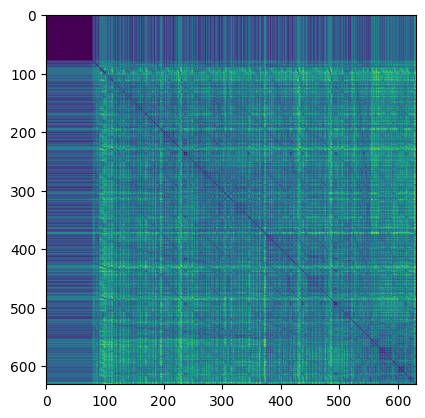

In [43]:
plt.imshow(adj_matrix_weight.toarray())

Commute relationship and weight factor calculation are finished for the given Hamiltonian

---

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import dwave_networkx as dnx
from dwave.system import DWaveSampler, DWaveCliqueSampler, EmbeddingComposite
from networkx.algorithms.approximation import max_clique

# HeH+ Test

In [7]:
molename = "HeH+"


In [8]:
qubits = len(df_node.iloc[0]["Pstring"])
N = qubits

In [9]:
# Commute graph
#commute_edges = df_edge[df_edge["commute"]&(df_edge["source"]!=qubits*"I")][["source", "target", "weight"]]
#node_list = df_node["Pstring"].isin(commute_edges["source"]) | df_node["Pstring"].isin(commute_edges["target"])
#commute_nodes = df_node.loc[node_list]

In [10]:
mu2 = 1
mu0 = N**2-N
mu1 = N**2

In [11]:
h_l = df_node.set_index(["Pstring"])["line"].multiply(mu0).to_dict()
q_commute_series = df_edge.set_index(["source", "target"])["commute"].astype(int).multiply(mu1)
q_weight_series = df_edge.set_index(["source","target"])["weight"].multiply(mu2)
Q = q_commute_series.multiply(q_weight_series).to_dict()

---

In [12]:
Sp_group = df_node.sample(n=176 if 176 < df_node.shape[0] else df_node.shape[0])["Pstring"]
Sp_group_I = Sp_group.drop(labels=[0])

In [13]:
# Small Examples
edge_sample = df_edge.loc[df_edge["source"].isin(Sp_group_I)|df_edge["target"].isin(Sp_group_I)]
edge_sample = edge_sample.loc[edge_sample["source"] != "IIII"]
G_sample =  nx.from_pandas_edgelist(edge_sample, source='source', target='target', edge_attr
=['commute', "weight"])


In [14]:
G_commute = nx.from_pandas_edgelist(edge_sample.loc[edge_sample["commute"]])

In [15]:
edgelist_commute= list(edge_sample.loc[edge_sample["commute"]][["source","target"]].itertuples(index=False,name=None))

In [17]:
c_colors =["red", "green", "yellow", "purple", "brown"]

In [18]:
# Classic solver, Boppana, R., & Halldórsson, M. M
# Max independent set method-> 
# In complement graph of the original graph, 
# Max clique has a 1 to 1 correspondense to Max independent set.
max_cliques = []
while len(G_commute.nodes) >0:
    clique = max_clique(G_commute)
    max_cliques.append(clique)
    for node in clique:
        G_commute.remove_node(node)
max_cliques

[{'IIIZ',
  'IIZI',
  'IIZZ',
  'IZII',
  'IZIZ',
  'IZZI',
  'ZIII',
  'ZIIZ',
  'ZIZI',
  'ZZII'},
 {'IXZX', 'IYZY', 'XXYY', 'XYYX', 'YXXY', 'YYXX'},
 {'XIXI', 'XZXI', 'XZXZ', 'YIYI', 'YZYI', 'YZYZ'},
 {'IXIX', 'IYIY', 'ZXZX', 'ZYZY'}]

In [19]:
G_commute = nx.from_pandas_edgelist(edge_sample.loc[edge_sample["commute"]])

In [20]:
# Default Quanum clique algorithm
max_cliques_q = []
while len(G_commute.nodes) >0:
    clique = dnx.maximum_clique(G_commute, sampler = sampler_cli)
    max_cliques_q.append(clique)
    for node in clique:
        G_commute.remove_node(node)
max_cliques_q

[['IIIZ',
  'IIZI',
  'IIZZ',
  'IZII',
  'IZIZ',
  'IZZI',
  'YYXX',
  'ZIII',
  'ZIIZ',
  'ZIZI',
  'ZZII'],
 ['IXIX', 'IYIY', 'XIXI', 'XZXZ', 'YIYI', 'YZYZ', 'ZXZX', 'ZYZY'],
 ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YZYI']]

In [21]:
pos = nx.spring_layout(G_sample)
#nx.kamada_kawai_layout(G_sample)

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_12556/1572192575.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


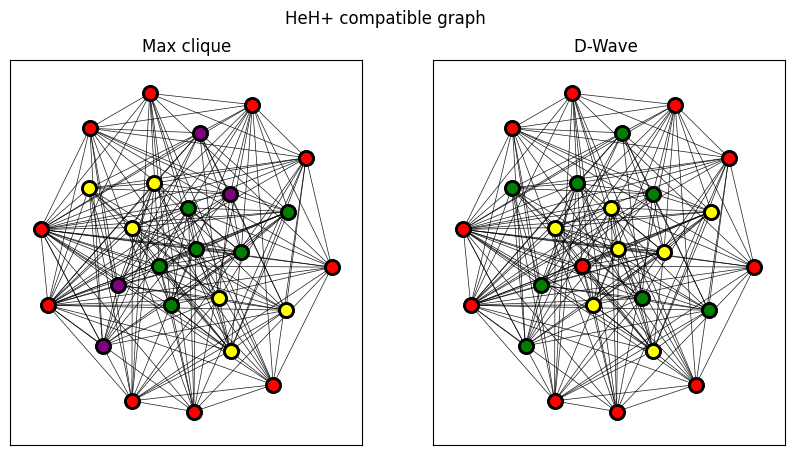

In [22]:
fig1, axes= plt.subplots(1,2, figsize=(10, 5))
# Draw all nodes
# Draw commute edges
for ax in axes:
    edges = nx.draw_networkx_edges(
        G_sample, pos, 
        edgelist=edgelist_commute,
        width=0.5, alpha=0.9,
        ax=ax)
    nodes = nx.draw_networkx_nodes(
        G_sample, pos=pos,
        node_size = 100,
        linewidths = 2,
        nodelist=G_sample.nodes,
        label = G_sample.nodes,
        edgecolors="black",
        ax=ax
    )
cliques_c = [max_cliques, max_cliques_q]
for ax, clique_c in zip(axes,cliques_c):
    for clique, color in zip(clique_c, c_colors):
        nx.draw_networkx_nodes(
            G_sample, pos=pos,
            node_size = 100,
            linewidths = 2,
            nodelist=clique,
            edgecolors="black",
            node_color=color,
            ax=ax
        )
axes[0].set_title("Max clique")
axes[1].set_title("D-Wave ")
fig1.suptitle(f"{molename} compatible graph")
fig1.show()

Both results are not different each other in a perpective of Min-Partition problem. The total number of partition is a consideraion variable and each local size of partition is not a significant factor.

In [23]:
# Commute test
clique_s = max_cliques_q[0]
print(clique_s)
edges_of_clique = edge_sample.loc[edge_sample.source.isin(clique_s) & edge_sample.target.isin(clique_s)]
print("Mutually Commute") if edges_of_clique.loc[edges_of_clique["commute"] == False].shape[0] ==0 else print("Not")

['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'YYXX', 'ZIII', 'ZIIZ', 'ZIZI', 'ZZII']
Not


In Latin square representation,

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Express above partition and graph in Latin partition.
zdim = df_node["zindex"].max() +1
xdim = df_node["xindex"].max() +1
basis = np.zeros([xdim, zdim])
basis[df_node["xindex"].values, df_node["zindex"].values] = 1
basis

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]])

In [26]:
df_node.head(4)

,index,Pstring,type,Z,X,Znum,Xnum,zindex,xindex,line
0,0,IIII,0,IIII,NaN,0,0,0,0,1
1,1,IIIZ,0,IIIZ,NaN,1,0,1,0,1
2,2,IIZI,0,IIZI,NaN,2,0,2,0,1
3,3,IIZZ,0,IIZZ,NaN,3,0,3,0,1


In [27]:
clique_collection  = max_cliques # max_cliques_q
weight_clique = np.arange(0, len(clique_collection)) +1

In [28]:
for clique, w in zip(clique_collection, weight_clique):
    index = df_node.loc[df_node["Pstring"].isin(clique)][["zindex", "xindex"]].values
    for i in index:
        basis[i[1], i[0]] = w

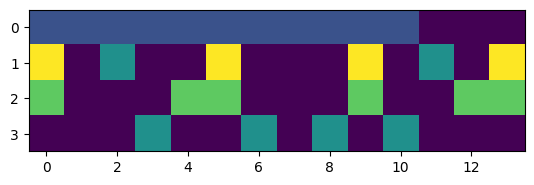

In [29]:
plt.imshow(basis)

## Max-Clique Problem - In Working 

Now we have to generate Min-Partition of the given Pauli set. 

1. Get Max-Mutually Commuting Set.
2. Eliminate 1. set nodes from the graph.
3. Repeats 1-2 steps until the remained set is an empty set.

There are two methods. 
1. Classic methods: Networkx library provides various max-cliques algorithms.
2. Quantum Annealer 
3. Digital Annealer

$$\mathcal{H} = \mu_0(-\sum Z_i) + \mu_1 (\sum_{i<j} h_{ij} Z_i Z_j) + \mu_2 (-\sum_{i <j} w_{ij} Z_i Z_j)$$

For $N$ qubit system, 

* $\mu_1 > N \mu_0$
* $\mu_0 > \frac{1}{2} N (N-1) \mu_2$

In [30]:
from copy import deepcopy

In [31]:
sampler_q = EmbeddingComposite(DWaveSampler()) # Max working variable number = 177, (5000 qubit machine)

In [298]:
#mu2 = 0
#mu0 = 1
#mu1 = 2
mu0 = N**2/2
mu1 = N**2
mu2 = 1

In [299]:
df_qubo = pd.DataFrame(columns = ["p1", "p2", "weight"])
df_qubo["p1"] = df_node["Pstring"]
df_qubo["p2"] = df_node["Pstring"]
df_qubo["weight"] = 1

In [315]:
df_w_qubo = deepcopy(df_qubo)
df_w_edge = deepcopy(df_edge[["source", "target", "commute", "weight"]])
df_w_edge = df_w_edge.loc[df_w_edge["source"] != "IIII"]

In [316]:
g_test = nx.from_pandas_edgelist(df_w_edge.loc[df_w_edge["commute"]])

In [317]:
dnx.maximum_clique(g_test,  sampler = sampler_cli)

['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZZII']

In [301]:
h_l = df_w_qubo.set_index(["p1", "p2"])["weight"].multiply(-mu0).to_dict()
q_commute_series = df_w_edge.set_index(["source", "target"])["commute"].astype(int).multiply(-mu1).add(mu1)
q_weight_series = df_w_edge.set_index(["source","target"])["weight"].multiply(-mu2)
Q = q_commute_series #q_commute_series.multiply(q_weight_series).to_dict()
H = {**h_l, **Q}

In [302]:
h_l

{('IIII', 'IIII'): -8.0,
 ('IIIZ', 'IIIZ'): -8.0,
 ('IIZI', 'IIZI'): -8.0,
 ('IIZZ', 'IIZZ'): -8.0,
 ('IZII', 'IZII'): -8.0,
 ('IZIZ', 'IZIZ'): -8.0,
 ('IZZI', 'IZZI'): -8.0,
 ('ZIII', 'ZIII'): -8.0,
 ('ZIIZ', 'ZIIZ'): -8.0,
 ('ZIZI', 'ZIZI'): -8.0,
 ('ZZII', 'ZZII'): -8.0,
 ('IXIX', 'IXIX'): -8.0,
 ('XIXI', 'XIXI'): -8.0,
 ('IXZX', 'IXZX'): -8.0,
 ('XXYY', 'XXYY'): -8.0,
 ('XZXI', 'XZXI'): -8.0,
 ('IYIY', 'IYIY'): -8.0,
 ('XZXZ', 'XZXZ'): -8.0,
 ('XYYX', 'XYYX'): -8.0,
 ('IYZY', 'IYZY'): -8.0,
 ('YXXY', 'YXXY'): -8.0,
 ('ZXZX', 'ZXZX'): -8.0,
 ('YIYI', 'YIYI'): -8.0,
 ('YYXX', 'YYXX'): -8.0,
 ('YZYI', 'YZYI'): -8.0,
 ('ZYZY', 'ZYZY'): -8.0,
 ('YZYZ', 'YZYZ'): -8.0}

In [303]:
q_commute_series

source  target
IIII    IIIZ       0
        IIZI       0
        IIZZ       0
        IZII       0
        IZIZ       0
                  ..
YYXX    ZYZY      16
        YZYZ      16
YZYI    ZYZY      16
        YZYZ       0
ZYZY    YZYZ       0
Name: commute, Length: 351, dtype: int64

In [304]:
sampleset = sampler_q.sample_qubo(H, num_reads=100, annealing_time=2)

In [305]:
list(pd.Series(list(sampleset.samples())[0].keys())[sampleset.record[0][0].astype(bool)])

['IIII',
 'IIZZ',
 'IZIZ',
 'IZZI',
 'XXYY',
 'XYYX',
 'YXXY',
 'YYXX',
 'ZIIZ',
 'ZIZI',
 'ZZII']

In [306]:
clique_collection = []
while df_w_qubo.shape[0] >0:
    sample_q_dwave = sampler_q.sample_qubo(H, num_reads=100, annealing_time= 2)
    clique = list(pd.Series(list(sample_q_dwave.samples())[0].keys())[sample_q_dwave.record[0][0].astype(bool)])
    
    clique_collection.append(clique)
    
    print(clique)
    #----
    #for node in clique:
    #    # Df node drop
    #    # ,,,
    #    pass
    df_w_qubo.drop(df_w_qubo[df_w_qubo["p1"].isin(clique)].index, inplace=True)
    drop_index = df_w_edge[df_w_edge["source"].isin(clique) | df_w_edge["target"].isin(clique)].index
    df_w_edge.drop(drop_index, inplace=True)

    #----
    h_l = df_w_qubo.set_index(["p1", "p2"])["weight"].multiply(-mu0).to_dict()
    q_commute_series = df_w_edge.set_index(["source", "target"])["commute"].astype(int).multiply(-mu1)
    q_weight_series = df_w_edge.set_index(["source","target"])["weight"].multiply(-mu2)
    Q = q_commute_series.multiply(q_weight_series).to_dict()
    H = {**h_l, **Q}
    print(f"D shape: {df_w_qubo.shape[0]}")
    #print(df_w_qubo)
clique_collection

['IIII', 'IIZZ', 'IZIZ', 'IZZI', 'XXYY', 'XYYX', 'YXXY', 'YYXX', 'ZIIZ', 'ZIZI', 'ZZII']
D shape: 16
['IIZI', 'XIXI', 'XZXI', 'XZXZ', 'YZYZ', 'ZIII']
D shape: 10
['IIIZ', 'IYIY', 'IYZY', 'IZII', 'ZYZY']
D shape: 5
['IXIX', 'YZYI', 'ZXZX']
D shape: 2
['IXZX', 'YIYI']
D shape: 0


[['IIII',
  'IIZZ',
  'IZIZ',
  'IZZI',
  'XXYY',
  'XYYX',
  'YXXY',
  'YYXX',
  'ZIIZ',
  'ZIZI',
  'ZZII'],
 ['IIZI', 'XIXI', 'XZXI', 'XZXZ', 'YZYZ', 'ZIII'],
 ['IIIZ', 'IYIY', 'IYZY', 'IZII', 'ZYZY'],
 ['IXIX', 'YZYI', 'ZXZX'],
 ['IXZX', 'YIYI']]

In [307]:
# Commute test
clique_s = clique_collection[1]
print(clique_s)
edges_of_clique = edge_sample.loc[edge_sample.source.isin(clique_s) & edge_sample.target.isin(clique_s)]
print("Mutually Commute") if edges_of_clique.loc[edges_of_clique["commute"] == False].shape[0] ==0 else print("Not")

['IIZI', 'XIXI', 'XZXI', 'XZXZ', 'YZYZ', 'ZIII']
Not


In [309]:
plot_clique_set = [max_cliques, max_cliques_q, clique_collection]

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_12556/2502798052.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


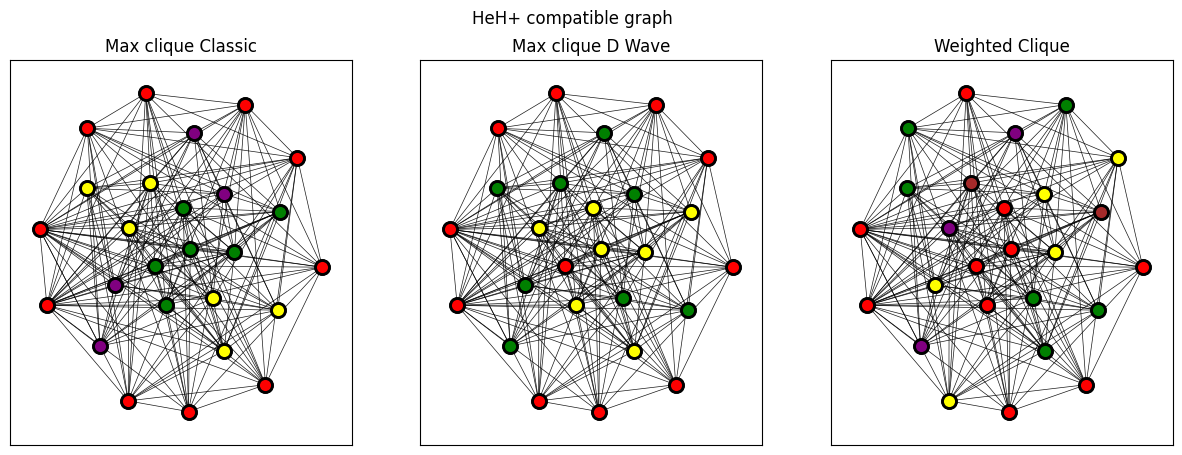

In [310]:
fig2, axes= plt.subplots(1,3, figsize=(15, 5))
# Draw all nodes
# Draw commute edges
for ax in axes:
    edges = nx.draw_networkx_edges(
        G_sample, pos, 
        edgelist=edgelist_commute,
        width=0.5, alpha=0.9,
        ax=ax)
    nodes = nx.draw_networkx_nodes(
        G_sample, pos=pos,
        node_size = 100,
        linewidths = 2,
        nodelist=G_sample.nodes,
        label = G_sample.nodes,
        edgecolors="black",
        ax=ax
    )
for ax, clique_collection in zip(axes, plot_clique_set):
    for clique, color in zip(clique_collection, c_colors):
        if "IIII" in clique:
            del(clique[clique.index("IIII")])
        nx.draw_networkx_nodes(
            G_sample, pos=pos,
            node_size = 100,
            linewidths = 2,
            nodelist=clique,
            edgecolors="black",
            node_color=color,
            ax=ax
        )
axes[0].set_title("Max clique Classic")
axes[1].set_title("Max clique D Wave")
axes[2].set_title("Weighted Clique")
fig2.suptitle(f"{molename} compatible graph")
fig2.show()

In [59]:
for clique in plot_clique_set:
    print(len(clique))

4
3
5


In [68]:
for clique in plot_clique_set:
    print(clique)

[{'IZZI', 'IZIZ', 'ZZII', 'ZIZI', 'IIZI', 'IZII', 'IIIZ', 'ZIII', 'ZIIZ', 'IIZZ'}, {'IYZY', 'YXXY', 'XXYY', 'XYYX', 'YYXX', 'IXZX'}, {'YIYI', 'YZYZ', 'XIXI', 'XZXI', 'YZYI', 'XZXZ'}, {'ZXZX', 'IXIX', 'IYIY', 'ZYZY'}]
[['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZIZI', 'ZZII'], ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI'], ['IXIX', 'IYIY', 'XIXI', 'XZXZ', 'YIYI', 'YZYZ', 'ZXZX', 'ZYZY']]
[['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZIZI', 'ZZII'], ['IXZX', 'IYZY', 'XIXI', 'XZXZ'], ['IYIY', 'XXYY', 'YXXY', 'ZYZY'], ['IXIX', 'XZXI', 'YZYI', 'ZXZX'], ['XYYX', 'YIYI', 'YYXX', 'YZYZ']]


In [70]:
for c in plot_clique_set[2]:
    print(len(c))

10
4
4
4
4


Optimize Pauli Frame method

In [71]:
cliq_coll_classic=[['ZIIZ', 'IIZI', 'IIIZ', 'IZZI', 'IIZZ', 'IZII', 'ZZII', 'IZIZ', 'ZIII', 'ZIZI'], ['YYXX', 'IYZY', 'XYYX', 'IXZX', 'YXXY', 'XXYY'], ['XZXI', 'YZYI', 'XIXI', 'YIYI', 'XZXZ', 'YZYZ'], ['IXIX', 'IYIY', 'ZXZX', 'ZYZY']]
cliq_coll_dwave=[['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZZII'], ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI', 'ZIZI'], ['IXIX', 'IYIY', 'XIXI', 'XZXZ', 'YIYI', 'YZYZ', 'ZXZX', 'ZYZY']]
cliq_coll_weight=[['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZIZI', 'ZZII'], ['XIXI', 'XXYY', 'XYYX', 'XZXZ'], ['IYIY', 'YXXY', 'YYXX', 'ZYZY'], ['IXZX', 'IYZY', 'YIYI', 'YZYZ'], ['IXIX', 'XZXI', 'YZYI', 'ZXZX']]

In [ ]:
# double key mapping to edge-df [Clique 1, Clique 2].

In [45]:
df_edge.loc[df_edge["commute"] == False]

,source,target,Znum_x,Xnum_x,Znum_y,Xnum_y,commute,weight
35,IIIZ,IXIX,1,0,0,5,False,0.5
37,IIIZ,IXZX,1,0,2,5,False,0.5
38,IIIZ,XXYY,1,0,3,15,False,1.5
40,IIIZ,IYIY,1,0,5,5,False,1.0
42,IIIZ,XYYX,1,0,6,15,False,1.5
...,...,...,...,...,...,...,...,...
338,ZXZX,YZYI,10,5,14,10,False,1.5
341,YIYI,YYXX,10,10,12,15,False,1.0
346,YYXX,ZYZY,12,15,15,5,False,1.0
347,YYXX,YZYZ,12,15,15,10,False,1.0


Compare to Pennylane QWC method

---

In [162]:
molename = "HF"
df_node = pd.read_csv("dataset_processed/"+f"{molename}-2.1_node.csv").drop(["Unnamed: 0",], axis=1)
df_node["line"] = 1
df_edge = pd.read_csv("dataset_processed/"+f"{molename}-2.1_edge.csv").drop(["Unnamed: 0",], axis=1)

In [163]:
qubits = len(df_node.iloc[0]["Pstring"])
N = qubits
print(N)

12


12 qubits -> $\max(2^12) = 4096$ is too big. 